# Basic Model Methods Demonstration

Comparison of Lifetime Reward (LR), Euler Residual (ER), and Bellman Residual (BR) methods.

**Key Difference**: 
- **LR Method**: Uses trajectory data (N samples, T+1 timesteps)
- **ER/BR Methods**: Use flattened i.i.d. data (N×T independent transitions)

This notebook demonstrates:
1. Data generation in both formats
2. Training all three methods
3. Loss curves and convergence comparison
4. Policy function comparison
5. Target network update monitoring (ER/BR only)

In [1]:

import sys
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Add project root to path
sys.path.append(os.path.abspath(".."))

from src.economy.data_generator import create_data_generator
from src.economy.parameters import EconomicParams, ShockParams
from src.trainers.config import NetworkConfig, OptimizationConfig, OptimizerConfig, AnnealingConfig, MethodConfig, EarlyStoppingConfig, RiskyDebtConfig
from src.trainers.basic import train_basic_lr, train_basic_er, train_basic_br


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Configure Logging for Notebook Display
from src.utils.logging_config import setup_notebook_logging
setup_notebook_logging('INFO')

Logging configured: level=INFO


In [3]:
# Demo/debug only: use small batch and max_iter
demo_batch_size=64
demo_n_iter=300

In [4]:
# 1. Configuration - All settings in one place

from src.trainers.config import (
    ExperimentConfig, NetworkConfig, OptimizationConfig, 
    OptimizerConfig, AnnealingConfig, MethodConfig, EarlyStoppingConfig
)
from src.economy.parameters import EconomicParams, ShockParams

# === Build Master Configuration ===
config = ExperimentConfig(
    name="Basic Model Demo",
    description="Comparison of LR, ER, BR methods for the basic investment model",
    
    # Economic Model Parameters
    params=EconomicParams.with_overrides(
        cost_convex=0.01,
        cost_fixed=0.0,
        cost_inject_fixed=0.0,
        cost_inject_linear=0.0
    ),
    
    # AR(1) Shock Process
    shock_params=ShockParams(mu=0.0, rho=0.7, sigma=0.15),
    
    # Network Architecture (small for speed)
    network=NetworkConfig(
        n_layers=2,
        n_neurons=32,
        activation="swish"
    ),
    
    # Optimization Settings
    optimization=OptimizationConfig(
        # Set small for demo, set large for triggering early_stopping
        batch_size=demo_batch_size,
        n_iter=demo_n_iter,  

        learning_rate=1e-4,
        learning_rate_critic=1e-3,  # BR only
        log_every=10,
        # stopping: set moderate tolerance for demo
        early_stopping=EarlyStoppingConfig(
            enabled=True,
            patience=5,
            eval_freq=50,
            lr_epsilon=1e-2,  
            lr_window=10,
            er_epsilon=1e-2,  
            br_critic_epsilon=1e-3,
            br_actor_epsilon=1e-3
        ),
        optimizer=OptimizerConfig(clipnorm=1.0)
    ),
    
    # Temperature Annealing Schedule
    annealing=AnnealingConfig(
        temperature_init=1.0,
        temperature_min=1e-4,
        decay=0.995
    ),
    
    # Method (placeholder, will be overridden per method)
    method=MethodConfig(name="basic_lr")
)

# Unpack for convenience (used by training functions)
params = config.params
shock_params = config.shock_params
net_config = config.network
opt_config = config.optimization
anneal_config = config.annealing

print("Configuration loaded successfully.")

[INFO] parameters: EconomicParams overrides: cost_convex: 0.0 -> 0.01
Configuration loaded successfully.


In [5]:
# 1.1 Configuration Summary - All parameters at a glance

# Print formatted summary to console
config.print_summary()

# Or view as interactive DataFrame (uncomment to use):
# config.summary()


EXPERIMENT: Basic Model Demo
Comparison of LR, ER, BR methods for the basic investment model
                                                     Value
Group        Parameter                                    
Economic     r_rate                                   0.04
             delta                                    0.15
             theta                                     0.7
             cost_convex                              0.01
             cost_fixed                                0.0
             tax                                       0.3
             cost_default                              0.4
             cost_inject_fixed                         0.0
             cost_inject_linear                        0.0
             frac_liquid                               0.5
Shock        rho                                       0.7
             sigma                                    0.15
             mu                                        0.0
Network      n_layers

In [6]:
# 2. Data Configuration

from src.trainers.config import DataConfig
from src.economy.data_generator import create_data_generator, cleanup_cache

data_config = DataConfig(
    master_seed=(20, 26),
    T=64,
    sim_batch_size=128,
    n_sim_batches=50,
    auto_compute_bounds=True,
    std_dev_multiplier=3.0,
    k_min_multiplier=0.2,
    k_max_multiplier=3.0,
    cache_dir="../data",
    save_to_disk=False
)

data_config.print_summary()


DATA CONFIGURATION
                                            Value
Group      Parameter                             
Simulation master_seed                   (20, 26)
           T (horizon)                         64
           sim_batch_size                     128
           n_sim_batches                       50
           total_samples                     6400
           N_val                   1280 (default)
           N_test                  6400 (default)
Bounds     auto_compute_bounds               True
           std_dev_multiplier (m)             3.0
           k_min_multiplier                   0.2
           k_max_multiplier                   3.0
Cache      cache_dir                      ../data
           save_to_disk                     False



In [7]:
# 2. Generate Synthetic Data

generator, _, bounds = create_data_generator(
    master_seed=data_config.master_seed,
    T=data_config.T,
    sim_batch_size=data_config.sim_batch_size,
    n_sim_batches=data_config.n_sim_batches,
    N_val=data_config.N_val,
    N_test=data_config.N_test,
    shock_params=shock_params,
    auto_compute_bounds=data_config.auto_compute_bounds,
    std_dev_multiplier=data_config.std_dev_multiplier,
    k_min_multiplier=data_config.k_min_multiplier,
    k_max_multiplier=data_config.k_max_multiplier,
    k_star_override=data_config.k_star_override,
    cache_dir=data_config.cache_dir,
    save_to_disk=data_config.save_to_disk,
    verbose=True
)

# Get training data in both formats
traj_data = generator.get_training_dataset()
flat_data = generator.get_flattened_training_dataset(include_debt=True)

# Get validation data
val_traj = generator.get_validation_dataset()
val_flat = generator.get_flattened_validation_dataset(include_debt=True)

print(f"\nTraining: {traj_data['k0'].shape[0]:,} trajectories, {flat_data['k'].shape[0]:,} transitions")
print(f"Validation: {val_traj['k0'].shape[0]:,} trajectories, {val_flat['k'].shape[0]:,} transitions")

2026-01-31 01:13:57.557411: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-31 01:13:57.557664: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-31 01:13:57.557675: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-31 01:13:57.557700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-31 01:13:57.557717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 Using provided ShockParams
 Auto-generated NORMALIZED bounds (k, b as multipliers on k*)
  k_bounds (normalized): (0.2, 3.0)
  b_bounds (normalized): (0.0, 2.3505911036994473)
  log_z_bounds: (-0.6301260378126043, 0.6301260378126043)
  k_star (for de-normalization): 77.23511488278521
  Master seed: (20, 26)
 === DataGenerator created ===
  Simulation batch size (n): 128
  Horizon (T): 64
  Simulation batches (J): 50
  Total samples: 6400
  NOTE: Training in normalized space. Multiply k by k_star=77.2351 to get levels.

Training: 6,400 trajectories, 409,600 transitions
Validation: 1,280 trajectories, 81,920 transitions


Saving figure to ../figures/data_format_comparison.png...


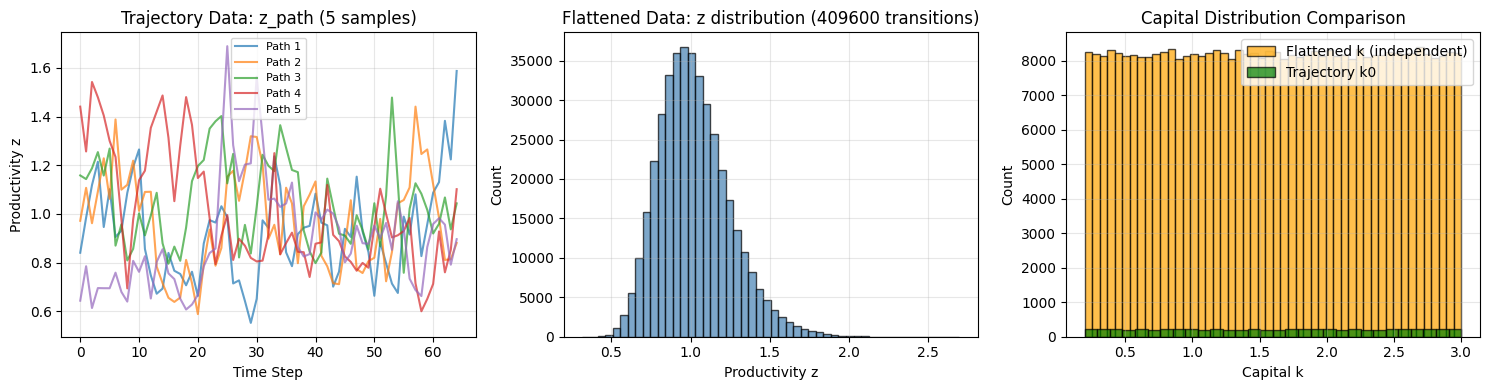


Key Observations:
  - Trajectory data: Time-dependent paths (left)
  - Flattened data: i.i.d. transitions (middle, right)
  - Independent k: Uniformly distributed across state space


In [8]:
# 2.1 Data Format Comparison

# Robust Path Definition
fig_dir = "../figures"
os.makedirs(fig_dir, exist_ok=True) # Ensure directory exists
plot_path = os.path.join(fig_dir, "data_format_comparison.png")

# Compare data formats visually
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Trajectory z_path (first 5 paths)
z_path = traj_data['z_path'].numpy()
for i in range(min(5, z_path.shape[0])):
    axes[0].plot(z_path[i], alpha=0.7, label=f'Path {i+1}')
axes[0].set_title('Trajectory Data: z_path (5 samples)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Productivity z')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Plot 2: Flattened z distribution
z_flat = flat_data['z'].numpy()
axes[1].hist(z_flat, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_title(f'Flattened Data: z distribution ({len(z_flat)} transitions)')
axes[1].set_xlabel('Productivity z')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

# Plot 3: Flattened k distribution (independent sampling)
k_flat = flat_data['k'].numpy()
k_traj = traj_data['k0'].numpy()
axes[2].hist(k_flat, bins=50, alpha=0.7, label='Flattened k (independent)', color='orange', edgecolor='black')
axes[2].hist(k_traj, bins=30, alpha=0.7, label='Trajectory k0', color='green', edgecolor='black')
axes[2].set_title('Capital Distribution Comparison')
axes[2].set_xlabel('Capital k')
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# ROBUST SAVING: Save before show
print(f"Saving figure to {plot_path}...")
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

# Display
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - Trajectory data: Time-dependent paths (left)")
print("  - Flattened data: i.i.d. transitions (middle, right)")
print("  - Independent k: Uniformly distributed across state space")

In [9]:
from src.utils.analysis import plot_dataset_stats, summarize_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Print numerical stats of a single batch
summarize_batch(traj_data, batch_idx=0)


Batch 0 Summary:
------------------------------------------------------------
k0         shape=(6400,)         mean=1.6039 std=0.8152 min=0.2006 max=2.9991
z0         shape=(6400,)         mean=1.0640 std=0.3826 min=0.5326 max=1.8778
b0         shape=(6400,)         mean=1.1832 std=0.6818 min=0.0004 max=2.3505
z_path     shape=(6400, 65)      mean=1.0238 std=0.2240 min=0.3172 max=2.6964


In [10]:
# 3. Train Lifetime Reward (LR) Method
method_config_lr = MethodConfig(name="basic_lr")

print("Training LR Method...")
result_lr = train_basic_lr(
    dataset=traj_data,
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_lr,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds,
    validation_data=val_traj
)

print(f"Final loss: {result_lr['history']['loss_LR'][-1]:.6f}")

Training LR Method...
[INFO] core: Starting Training Loop: Method=basic_lr, Iterations=300, EarlyStopping=enabled
[INFO] core: Dataset format validation passed for LR method
[INFO] core: Convergence checker created. N_anneal=2297, Patience=5
[INFO] core: Iter 100: loss_LR=-32.1394 Temp (log10)=-0.22
[INFO] core: Iter 200: loss_LR=-33.3046 Temp (log10)=-0.43
[INFO] core: Iter 300: loss_LR=-34.2525 Temp (log10)=-0.65
[INFO] core: Training finished in 246.34s (stopped_early=False)
Final loss: -34.252541


In [11]:
# 4. Train Euler Residual (ER) Method
method_config_er = MethodConfig(name="basic_er", polyak_tau=0.995)

print("Training ER Method...")
result_er = train_basic_er(
    dataset=flat_data,
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_er,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds,
    validation_data=val_flat
)

print(f"Final loss: {result_er['history']['loss_ER'][-1]:.6f}")

Training ER Method...
[INFO] core: Starting Training Loop: Method=basic_er, Iterations=300, EarlyStopping=enabled


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'basic_policy_network_2' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)


[INFO] core: Dataset format validation passed for ER method
[INFO] core: Convergence checker created. N_anneal=2297, Patience=5
[INFO] core: Iter 100: loss_ER=0.1678 Temp (log10)=-0.22
[INFO] core: Iter 200: loss_ER=0.1435 Temp (log10)=-0.43
[INFO] core: Iter 300: loss_ER=0.1646 Temp (log10)=-0.65
[INFO] core: Training finished in 21.70s (stopped_early=False)
Final loss: 0.164565


In [12]:
# 5. Train Bellman Residual (BR) Method
method_config_br = MethodConfig(name="basic_br", n_critic=10, polyak_tau=0.995)

print("Training BR Method...")
result_br = train_basic_br(
    dataset=flat_data,
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_br,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds,
    validation_data=val_flat
)

print(f"Final critic loss: {result_br['history']['loss_critic'][-1]:.6f}")

Training BR Method...
[INFO] core: Starting Training Loop: Method=basic_br, Iterations=300, EarlyStopping=enabled


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'basic_policy_network_4' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'basic_value_network_3' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that gen

[INFO] core: Dataset format validation passed for BR method
[INFO] core: Convergence checker created. N_anneal=2297, Patience=5
[INFO] core: Iter 100: actor=-2.8226 critic=0.0019 Temp (log10)=-0.22
[INFO] core: Iter 200: actor=-3.3995 critic=0.0003 Temp (log10)=-0.43
[INFO] core: Iter 300: actor=-3.5756 critic=0.0037 Temp (log10)=-0.65
[INFO] core: Training finished in 170.70s (stopped_early=False)
Final critic loss: 0.003664


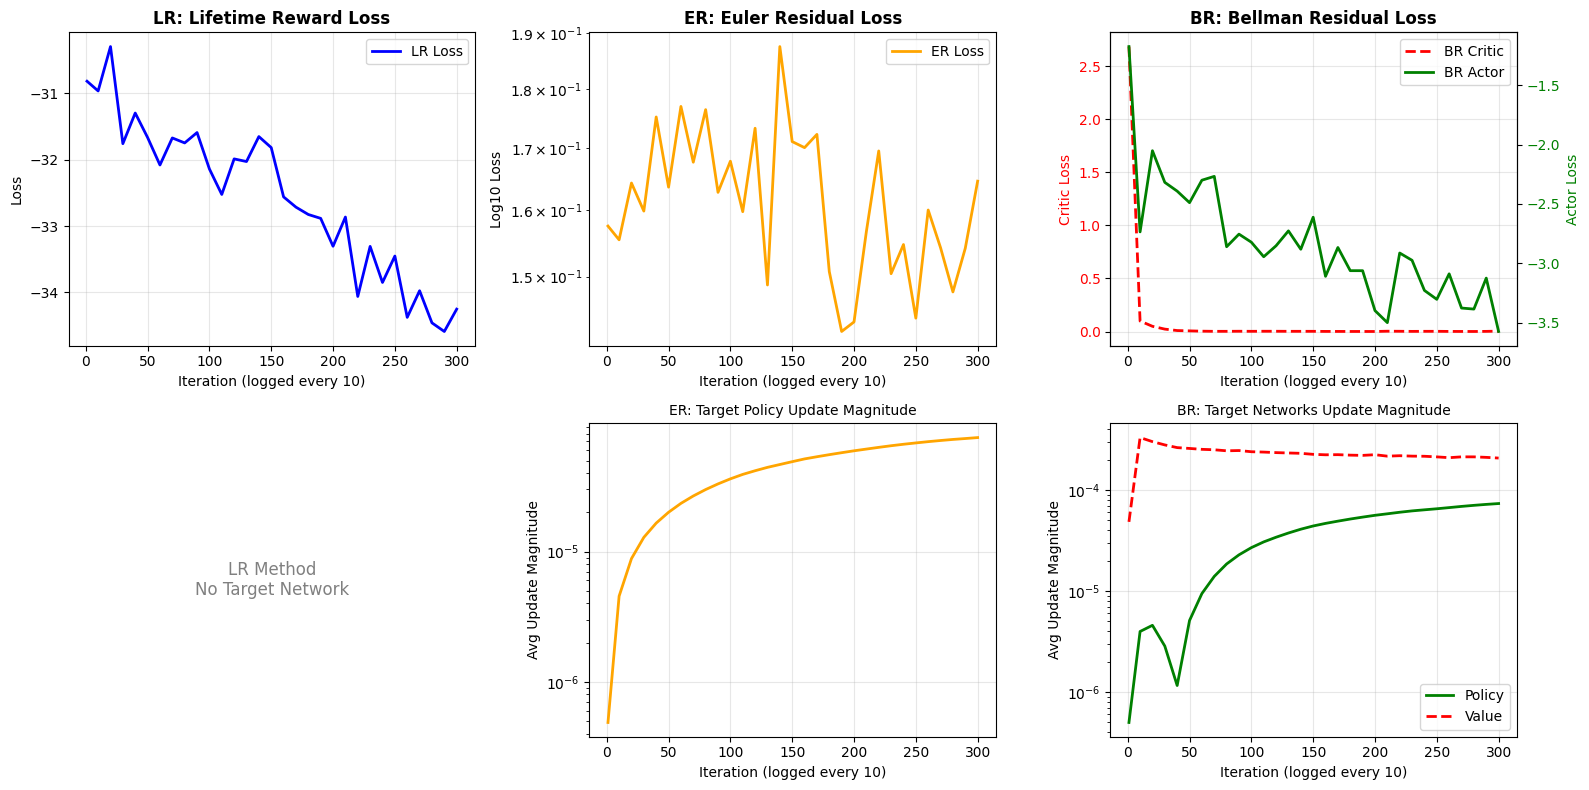


Target Network Updates:
  ER: Final target policy update = 7.499473e-05
  BR: Final target policy update = 7.355921e-05
  BR: Final target value update  = 2.075461e-04


In [13]:
# 6. Loss Curves and Target Network Updates

# Dynamic label for x-axis
freq_str = f"Iteration (logged every {opt_config.log_every})"

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Row 1: Main losses
# 1.1 Lifetime Reward
iter_lr = result_lr['history']['iteration']
axes[0, 0].plot(iter_lr, result_lr['history']['loss_LR'], label='LR Loss', color='blue', linewidth=2)
axes[0, 0].set_title('LR: Lifetime Reward Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel(freq_str)
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 1.2 Euler Residual
iter_er = result_er['history']['iteration']
axes[0, 1].plot(iter_er, result_er['history']['loss_ER'], label='ER Loss', color='orange', linewidth=2)
axes[0, 1].set_title('ER: Euler Residual Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(freq_str)
axes[0, 1].set_ylabel('Log10 Loss')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 1.3 Bellman Residual (Dual Axis)
ax_br = axes[0, 2]
iter_br = result_br['history']['iteration']

# Critic on primary Y
line1 = ax_br.plot(iter_br, result_br['history']['loss_critic'], label='BR Critic', color='red', linewidth=2, linestyle='--')
ax_br.set_ylabel('Critic Loss', color='red')
ax_br.tick_params(axis='y', labelcolor='red')

# Actor on secondary Y
ax_br2 = ax_br.twinx()
line2 = ax_br2.plot(iter_br, result_br['history']['loss_actor'], label='BR Actor', color='green', linewidth=2)
ax_br2.set_ylabel('Actor Loss', color='green')
ax_br2.tick_params(axis='y', labelcolor='green')

# Combined Legend
lines = line1 + line2
labels_box = [l.get_label() for l in lines]
ax_br.legend(lines, labels_box, loc='upper right')

ax_br.set_title('BR: Bellman Residual Loss', fontsize=12, fontweight='bold')
ax_br.set_xlabel(freq_str)
ax_br.grid(True, alpha=0.3)

# Row 2: Target network updates (ER and BR only)
# 2.1 Empty (LR has no target network)
axes[1, 0].text(0.5, 0.5, 'LR Method\nNo Target Network', ha='center', va='center', fontsize=12, color='gray')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['bottom'].set_visible(False)
axes[1, 0].spines['left'].set_visible(False)

# 2.2 ER Target Policy Update
if 'target_policy_update' in result_er['history']:
    axes[1, 1].plot(iter_er, result_er['history']['target_policy_update'], color='orange', linewidth=2)
    axes[1, 1].set_title('ER: Target Policy Update Magnitude', fontsize=10)
    axes[1, 1].set_xlabel(freq_str)
    axes[1, 1].set_ylabel('Avg Update Magnitude')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No target update data', ha='center', va='center', color='gray')

# 2.3 BR Target Networks Update
if 'target_policy_update' in result_br['history'] and 'target_value_update' in result_br['history']:
    axes[1, 2].plot(iter_br, result_br['history']['target_policy_update'], label='Policy', color='green', linewidth=2)
    axes[1, 2].plot(iter_br, result_br['history']['target_value_update'], label='Value', color='red', linewidth=2, linestyle='--')
    axes[1, 2].set_title('BR: Target Networks Update Magnitude', fontsize=10)
    axes[1, 2].set_xlabel(freq_str)
    axes[1, 2].set_ylabel('Avg Update Magnitude')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 2].text(0.5, 0.5, 'No target update data', ha='center', va='center', color='gray')

plt.tight_layout()
plt.savefig("../figures/basic_loss_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nTarget Network Updates:")
if 'target_policy_update' in result_er['history']:
    print(f"  ER: Final target policy update = {result_er['history']['target_policy_update'][-1]:.6e}")
if 'target_policy_update' in result_br['history']:
    print(f"  BR: Final target policy update = {result_br['history']['target_policy_update'][-1]:.6e}")
    print(f"  BR: Final target value update  = {result_br['history']['target_value_update'][-1]:.6e}")

In [14]:
# 8. Summary Statistics

# Create summary table
summary_data = {
    'Method': ['LR', 'ER', 'BR'],
    'Data Format': ['Trajectory', 'Flattened', 'Flattened'],
    'Target Network': ['No', 'Yes (Policy)', 'Yes (Policy+Value)'],
    'Final Loss': [
        result_lr['history']['loss_LR'][-1],
        result_er['history']['loss_ER'][-1],
        result_br['history']['loss_critic'][-1]
    ],
    'Data Samples': [
        f"{traj_data['k0'].shape[0]} traj.",
        f"{flat_data['k'].shape[0]} trans.",
        f"{flat_data['k'].shape[0]} trans."
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)


TRAINING SUMMARY
Method Data Format     Target Network  Final Loss  Data Samples
    LR  Trajectory                 No  -34.252541    6400 traj.
    ER   Flattened       Yes (Policy)    0.164565 409600 trans.
    BR   Flattened Yes (Policy+Value)    0.003664 409600 trans.


Steady State Capital (k*):
  LR: 1.9871
  ER: 2.0024
  BR: 2.0103


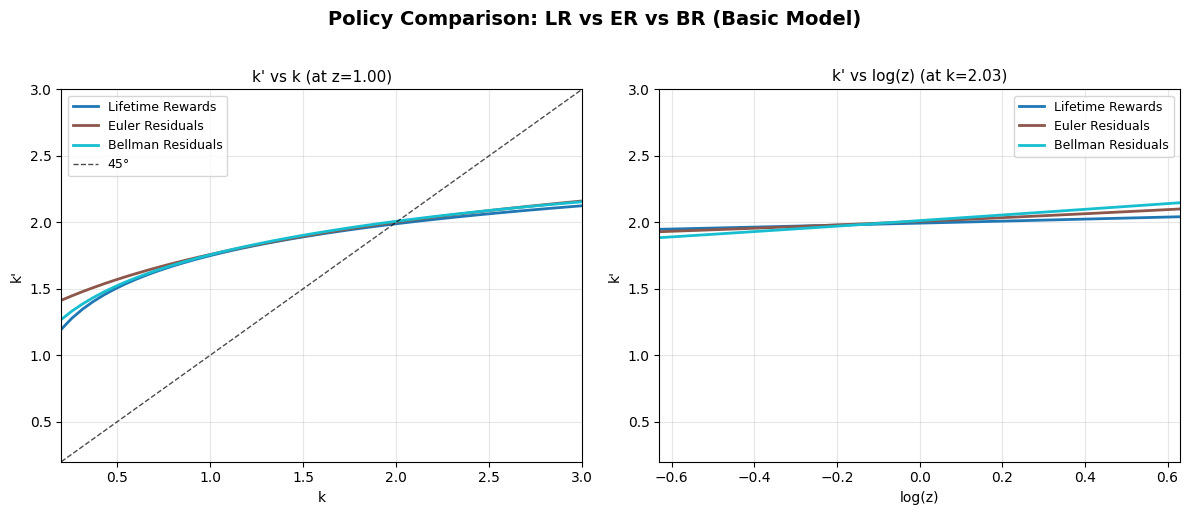

In [15]:
# =============================================================================
# 7. Policy Comparison (LR vs ER vs BR) - Basic Model
# =============================================================================

from src.utils.analysis import get_steady_state_policy, evaluate_policy
from src.utils.plotting import plot_policy_panels, plot_policy_comparison_panels

k_bounds = bounds['k']
logz_bounds = bounds['log_z']

# Find steady states (basic model - no b_bounds)
ss_lr = get_steady_state_policy(result_lr, k_bounds=k_bounds, logz_bounds=logz_bounds)
ss_er = get_steady_state_policy(result_er, k_bounds=k_bounds, logz_bounds=logz_bounds)
ss_br = get_steady_state_policy(result_br, k_bounds=k_bounds, logz_bounds=logz_bounds)

print("Steady State Capital (k*):")
print(f"  LR: {ss_lr['k_star_val']:.4f}")
print(f"  ER: {ss_er['k_star_val']:.4f}")
print(f"  BR: {ss_br['k_star_val']:.4f}")

# Evaluate policies on grid (use BR's steady state as reference)
grid_lr = evaluate_policy(result_lr, k_bounds=k_bounds, logz_bounds=logz_bounds,
                          fixed_k_val=ss_br['k_star_val'])
grid_er = evaluate_policy(result_er, k_bounds=k_bounds, logz_bounds=logz_bounds,
                          fixed_k_val=ss_br['k_star_val'])
grid_br = evaluate_policy(result_br, k_bounds=k_bounds, logz_bounds=logz_bounds,
                          fixed_k_val=ss_br['k_star_val'])

# Multi-panel comparison plot
fig = plot_policy_comparison_panels(
    [grid_lr, grid_er, grid_br],
    labels=['Lifetime Rewards', 'Euler Residuals', 'Bellman Residuals'],
    suptitle="Policy Comparison: LR vs ER vs BR (Basic Model)"
)
plt.tight_layout()
plt.savefig("../figures/basic_policy_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

---

# Risky Debt Model: BR Method

This section demonstrates the **Bellman Residual (BR) method** for the Risky Debt model.

**Key Differences from Basic Model:**
- **Three Networks**: Policy $(k,b,z) \to (k',b')$, Value $(k,b,z) \to \widetilde{V}$, Price $(k',b',z) \to q$
- **Target Networks**: All three networks have corresponding target networks with Polyak averaging
- **Bond Pricing**: Price network outputs bond price $q \in [0, 1/(1+r)]$ instead of interest rate
- **Default Probability**: Uses Gumbel-Sigmoid for smooth exploration around default boundary
- **Effective Value**: $V_{eff} = (1-p) \cdot V$ where $p$ is default probability

In [16]:
# Risky Debt Imports
from src.trainers.risky import train_risky_br
from src.networks.network_risky import build_risky_networks, compute_effective_value

In [17]:
# Risky Debt Configuration

from src.trainers.config import (
    ExperimentConfig, NetworkConfig, OptimizationConfig, 
    OptimizerConfig, AnnealingConfig, MethodConfig, EarlyStoppingConfig, RiskyDebtConfig
)
from src.economy.parameters import EconomicParams, ShockParams

config_risky = ExperimentConfig(
    name="Risky Debt BR Demo",
    description="Bellman Residual method with endogenous default and bond pricing",
    params=EconomicParams.with_overrides(
        cost_convex=0.01,
        cost_fixed=0.01,
        cost_inject_fixed=0.01,
        cost_inject_linear=0.01,
        cost_default=0.4,
        tax=0.3
    ),
    shock_params=ShockParams(mu=0.0, rho=0.7, sigma=0.15),
    network=NetworkConfig(n_layers=2, n_neurons=32, activation="swish"),
    optimization=OptimizationConfig(
        batch_size=demo_batch_size,
        n_iter=demo_n_iter,
        learning_rate=1e-4,
        learning_rate_critic=1e-3,
        log_every=10,
        early_stopping=EarlyStoppingConfig(
            enabled=True,
            patience=5,
            eval_freq=50,
            br_critic_epsilon=1e-5,
            br_actor_epsilon=1e-4
        ),
        optimizer=OptimizerConfig(clipnorm=1.0)
    ),
    annealing=AnnealingConfig(
        temperature_init=1.0,
        temperature_min=1e-4,
        decay=0.995,
        logit_clip=5.0
    ),
    method=MethodConfig(
        name="risky_br",
        n_critic=10,
        polyak_tau=0.995,
        risky=RiskyDebtConfig(weight_br=1.0)
    )
)

# Unpack for convenience
params_risky = config_risky.params
shock_params_risky = config_risky.shock_params
net_config_risky = config_risky.network
opt_config_risky = config_risky.optimization
anneal_config_risky = config_risky.annealing
method_config_risky_br = config_risky.method

print("Risky Debt configuration loaded")

[INFO] parameters: EconomicParams overrides: cost_convex: 0.0 -> 0.01, cost_fixed: 0.0 -> 0.01, cost_inject_fixed: 0.0 -> 0.01, cost_inject_linear: 0.0 -> 0.01
Risky Debt configuration loaded


In [18]:
# Risky Debt Configuration Summary
config_risky.print_summary()


EXPERIMENT: Risky Debt BR Demo
Bellman Residual method with endogenous default and bond pricing
                                                     Value
Group        Parameter                                    
Economic     r_rate                                   0.04
             delta                                    0.15
             theta                                     0.7
             cost_convex                              0.01
             cost_fixed                               0.01
             tax                                       0.3
             cost_default                              0.4
             cost_inject_fixed                        0.01
             cost_inject_linear                       0.01
             frac_liquid                               0.5
Shock        rho                                       0.7
             sigma                                    0.15
             mu                                        0.0
Network      n_lay

In [19]:
# Train Risky Debt BR Method

print("Training Risky Debt BR Method...")
result_risky_br = train_risky_br(
    dataset=flat_data,
    net_config=net_config_risky,
    opt_config=opt_config_risky,
    method_config=method_config_risky_br,
    anneal_config=anneal_config_risky,
    params=params_risky,
    shock_params=shock_params_risky,
    bounds=bounds
)

print(f"Final critic loss: {result_risky_br['history']['loss_critic'][-1]:.6f}")
print(f"Final actor loss:  {result_risky_br['history']['loss_actor'][-1]:.6f}")
print(f"Final price loss:  {result_risky_br['history']['loss_price'][-1]:.6f}")

Training Risky Debt BR Method...
[INFO] risky: RiskyDebtTrainerBR initialized: weight_br=1.00, n_critic=10, polyak_tau=0.995
[INFO] core: Starting Training Loop: Method=risky_br, Iterations=300, EarlyStopping=enabled


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'risky_policy_network_1' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:745: UserWarning: Model 'risky_value_network_1' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that gen

[INFO] core: Dataset format validation passed for BR method
[INFO] core: Convergence checker created. N_anneal=2297, Patience=5
[INFO] core: Iter 100: actor=-1.1041 critic=0.0055 price=0.0070 Temp (log10)=-0.22
[INFO] core: Iter 200: actor=-1.5101 critic=0.0029 price=0.0009 Temp (log10)=-0.43
[INFO] core: Iter 300: actor=-1.7362 critic=0.0001 price=0.0038 Temp (log10)=-0.65
[INFO] core: Training finished in 370.26s (stopped_early=False)
Final critic loss: 0.000100
Final actor loss:  -1.736199
Final price loss:  0.003786


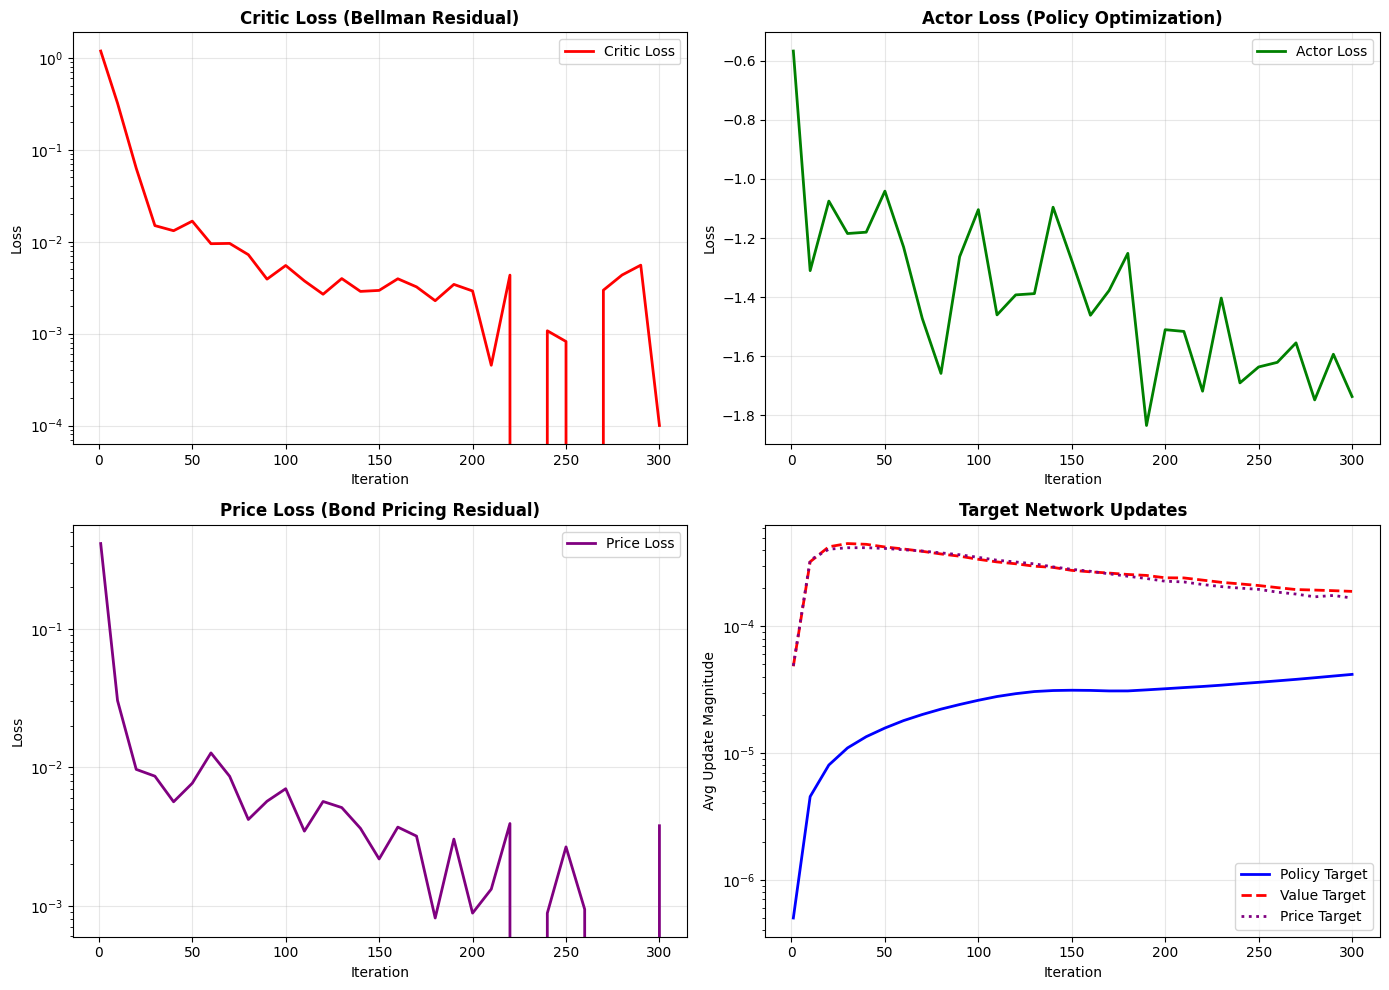

Figure saved to ../figures/risky_br_loss_curves.png


In [20]:
# Risky Debt BR: Loss Curves Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
iter_risky = result_risky_br['history']['iteration']

# 1. Critic Loss (Bellman Residual)
axes[0, 0].plot(iter_risky, result_risky_br['history']['loss_critic'], 
                color='red', linewidth=2, label='Critic Loss')
axes[0, 0].set_title('Critic Loss (Bellman Residual)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Actor Loss (Policy Gradient)
axes[0, 1].plot(iter_risky, result_risky_br['history']['loss_actor'], 
                color='green', linewidth=2, label='Actor Loss')
axes[0, 1].set_title('Actor Loss (Policy Optimization)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Price Loss (Bond Pricing Residual)
axes[1, 0].plot(iter_risky, result_risky_br['history']['loss_price'], 
                color='purple', linewidth=2, label='Price Loss')
axes[1, 0].set_title('Price Loss (Bond Pricing Residual)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Target Network Updates (if available)
has_target_data = ('target_policy_update' in result_risky_br['history'] and 
                   'target_value_update' in result_risky_br['history'])

if has_target_data:
    axes[1, 1].plot(iter_risky, result_risky_br['history']['target_policy_update'], 
                    label='Policy Target', color='blue', linewidth=2)
    axes[1, 1].plot(iter_risky, result_risky_br['history']['target_value_update'], 
                    label='Value Target', color='red', linewidth=2, linestyle='--')
    if 'target_price_update' in result_risky_br['history']:
        axes[1, 1].plot(iter_risky, result_risky_br['history']['target_price_update'], 
                        label='Price Target', color='purple', linewidth=2, linestyle=':')
    axes[1, 1].set_title('Target Network Updates', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Avg Update Magnitude')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    # Summary stats instead
    axes[1, 1].axis('off')
    summary_text = (
        f"Risky Debt BR Summary\n"
        f"{'='*30}\n\n"
        f"Final Critic Loss: {result_risky_br['history']['loss_critic'][-1]:.4f}\n"
        f"Final Actor Loss:  {result_risky_br['history']['loss_actor'][-1]:.4f}\n"
        f"Final Price Loss:  {result_risky_br['history']['loss_price'][-1]:.4f}\n\n"
        f"Iterations: {len(iter_risky) * opt_config_risky.log_every}\n"
        f"Batch Size: {opt_config_risky.batch_size}\n"
        f"Critic Steps: {method_config_risky_br.n_critic}\n"
        f"Polyak τ: {method_config_risky_br.polyak_tau}"
    )
    axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes,
                    fontsize=11, verticalalignment='center', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig("../figures/risky_br_loss_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/risky_br_loss_curves.png")

Risky Debt Steady State:
  k* = 1.6610
  b* = 1.3875


/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/src/utils/plotting.py:199: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=9)


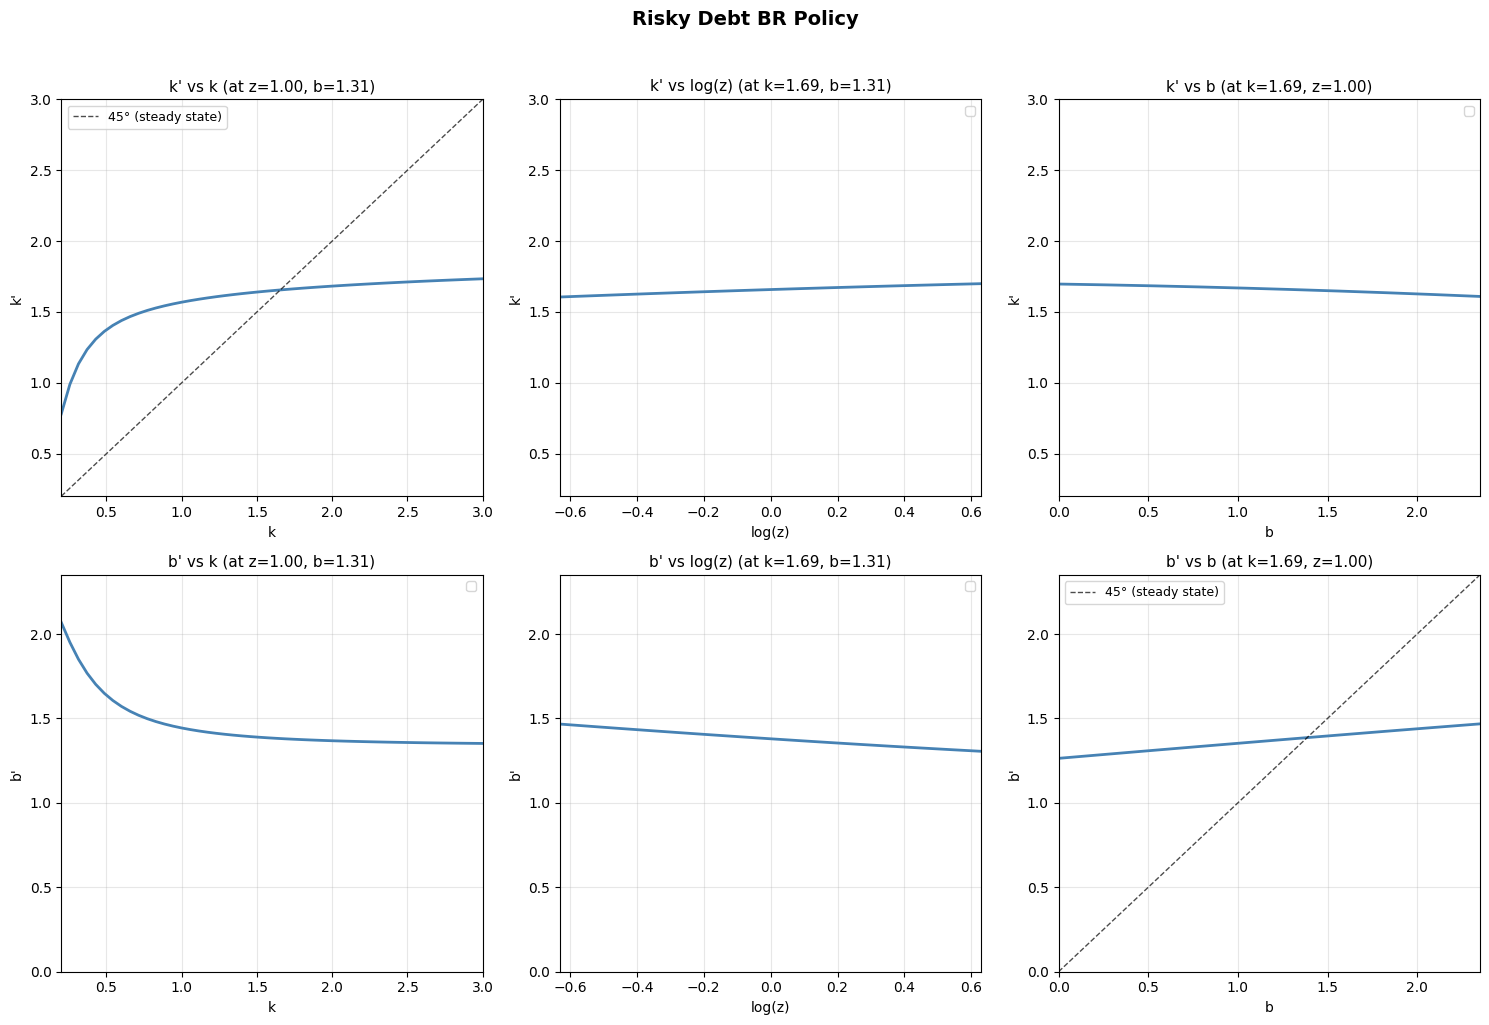

In [21]:
# =============================================================================
# Risky Debt Policy Visualization
# =============================================================================

from src.utils.analysis import get_steady_state_policy, evaluate_policy
from src.utils.plotting import plot_policy_panels

k_bounds = bounds['k']
logz_bounds = bounds['log_z']
b_bounds = bounds['b']

# Find steady state for risky model
ss_risky = get_steady_state_policy(result_risky_br, k_bounds=k_bounds, 
                                    logz_bounds=logz_bounds, b_bounds=b_bounds)

print("Risky Debt Steady State:")
print(f"  k* = {ss_risky['k_star_val']:.4f}")
print(f"  b* = {ss_risky['b_star_val']:.4f}")

# Evaluate policy on grid
grid_risky = evaluate_policy(result_risky_br, k_bounds=k_bounds, 
                             logz_bounds=logz_bounds, b_bounds=b_bounds,
                             fixed_k_val=ss_risky['k_star_val'],
                             fixed_b_val=ss_risky['b_star_val'])

# 2x3 panel plot for risky model
fig = plot_policy_panels(grid_risky, suptitle="Risky Debt BR Policy")
plt.savefig("../figures/risky_br_policy.png", dpi=150, bbox_inches='tight')
plt.show()